DSCI 100 Project Proposal: 
- Group 44, section 007
- Lucas Alexander, Eric Lee, James He, Sadaf Ayisha Hamidi

***The Nowcast: Who cares if it will rain? Indirectly determining if it is raining with atmospheric measurements***

***INTRODUCTION***
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

**From the proposal**

    METAR (Meteorological Aerodrome Reports) is the most common and widely accepted format for outputting data from weather measurements. Uploaded essentially constantly, there is a huge outflow of data on atmospheric conditions for nearly every moment, in nearly every inhabited place. They measure such variables as cloud cover, wind speed, and precipitation, amongst others. While predicting a weather forecast is a notoriously difficult task, it is much easier to make a "nowcast", where one makes guesses about current weather conditions. In this project, we intend to use the METAR data from a weather station just outside Des Moines from May 22 - June 15, 2008, to determine whether or not there is current precipitation at any point within the given time frame. We chose this period of time as a major flood occurred at this time in Iowa, which will give us a more even distribution of our two categorical variables (raining and not raining), hopefully improving the accuracy of our K-nearest neighbor model. The station takes measurements every 20 minutes, and the data are collected and uploaded by Iowa State University.

***METHODS AND RESULTS***
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
    - loads data from the original source on the web (DONE)
    - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis (DONE)
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis (DONE)
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis (DONE)
    - performs the data analysis (DONE)
    - creates a visualization of the analysis (TO DO)
    - note: all tables and figure should have a figure/table number and a legend
    
**From the proposal**

    Our group analysis project will consist of all numerical variables contained within the METAR data set, as variables of other data types were selected out as they cannot be used by the K-nearest neighbor algorithm. These variables are air temperature (tmpf), dew-point temperature (dwpf), relative humidity percentage (relh), wind direction in degrees from true north (drct), wind speed (sknt), visibility (vsby), and pressure altimeter (alti). Our categorical variable is 1-hour precipitation (precip). We will use the K-nearest neighbor algorithm to solve this basic classification problem and tune our model to determine the optimal number of neighbors using cross-validation. Using this model, we will generate a workflow which should tell us an observation's correct binary classification. We can visualize the results using a bar plot that shows the relative amounts of each class in the test set, filled with color relative to the corresponding percent accuracy of our classifier.

***CODING SECTION BELOW***

In [88]:
#loading appropriate libraries and setting seed
library(tidyverse)
library(tidymodels)
set.seed(420)

In [86]:
#loading data into R
metar_data <- read_csv("https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=IKV&data=all&year1=2008&month1=5&day1=22&year2=2008&month2=6&day2=15&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=T&direct=no&report_type=3&report_type=4")

#wrangling data to elimate non-predictor variables
#formatted predicted class column "precip" so it can be used by KNN algorithm

metar_data['p01i'][metar_data['p01i'] > 0 ] <- 1

metar_wrangled <- metar_data |>  
    mutate(precip = as_factor(p01i)) |>
    select(-station, -valid, -metar, -snowdepth, -wxcodes, 
           -mslp, -peak_wind_gust, -peak_wind_drct, -peak_wind_gust, 
           -skyc1, -skyc2, -skyc3, -skyc4, -peak_wind_time, -ice_accretion_1hr, 
           -ice_accretion_3hr, -ice_accretion_6hr, -p01i, - skyl4, -skyl1, -skyl2, -skyl3, -gust) |>
        filter(!is.na(precip), !is.na(tmpf), !is.na(dwpf), !is.na(relh), 
               !is.na(drct), !is.na(sknt), !is.na(alti), !is.na(vsby), !is.na(feel))

#removing rows with sky level or gust NA
# metar_wrangled <- metar_data |>  
#     mutate(precip = as_factor(p01i)) |>
#     select(-station, -valid, -metar, -snowdepth, -wxcodes, 
#            -mslp, -peak_wind_gust, -peak_wind_drct, -peak_wind_gust, 
#            -skyc1, -skyc2, -skyc3, -skyc4, -peak_wind_time, -ice_accretion_1hr, 
#            -ice_accretion_3hr, -ice_accretion_6hr, -p01i, - skyl4) |>
#         filter(!is.na(precip), !is.na(tmpf), !is.na(dwpf), !is.na(relh), 
#                !is.na(drct), !is.na(sknt), !is.na(alti), !is.na(vsby), !is.na(feel),!is.na(skyl1), !is.na(skyl2), !is.na(skyl3), !is.na(gust))
#only 63 data points, therefore we have to get rid of skyl1-3 + gust

head(metar_wrangled)

Rows: 4114 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): station, skyc1, skyc2, skyc3, wxcodes, metar
dbl  (13): tmpf, dwpf, relh, drct, sknt, p01i, alti, vsby, gust, skyl1, skyl...
lgl  (10): mslp, skyc4, skyl4, ice_accretion_1hr, ice_accretion_3hr, ice_acc...
dttm  (1): valid

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tmpf,dwpf,relh,drct,sknt,alti,vsby,feel,precip
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
59.0,46.4,62.92,120,7,29.87,10,59.0,0
59.0,49.0,69.38,100,8,29.86,10,59.0,1
58.0,48.0,69.27,100,10,29.84,10,58.0,1
57.2,46.4,67.12,100,11,29.84,10,57.2,1
58.0,49.0,71.91,90,14,29.80,10,58.0,1
59.0,49.0,69.38,140,8,29.84,10,59.0,1


In [61]:
#splitting data into test and training sets
metar_split <- initial_split(metar_wrangled, prop = 0.75, strata = precip)
metar_training <- training(metar_split)
metar_testing <- testing(metar_split)

#summary table with percent distribution of precip classes: exploratory analysis
train_rows <- nrow(metar_training)
metar_classes <- metar_training |>
    group_by(precip) |>
    summarize(
        count = n(),
        percentage = n()/train_rows*100)

metar_classes  

precip,count,percentage
<fct>,<int>,<dbl>
0,896,77.64298
1,258,22.35702


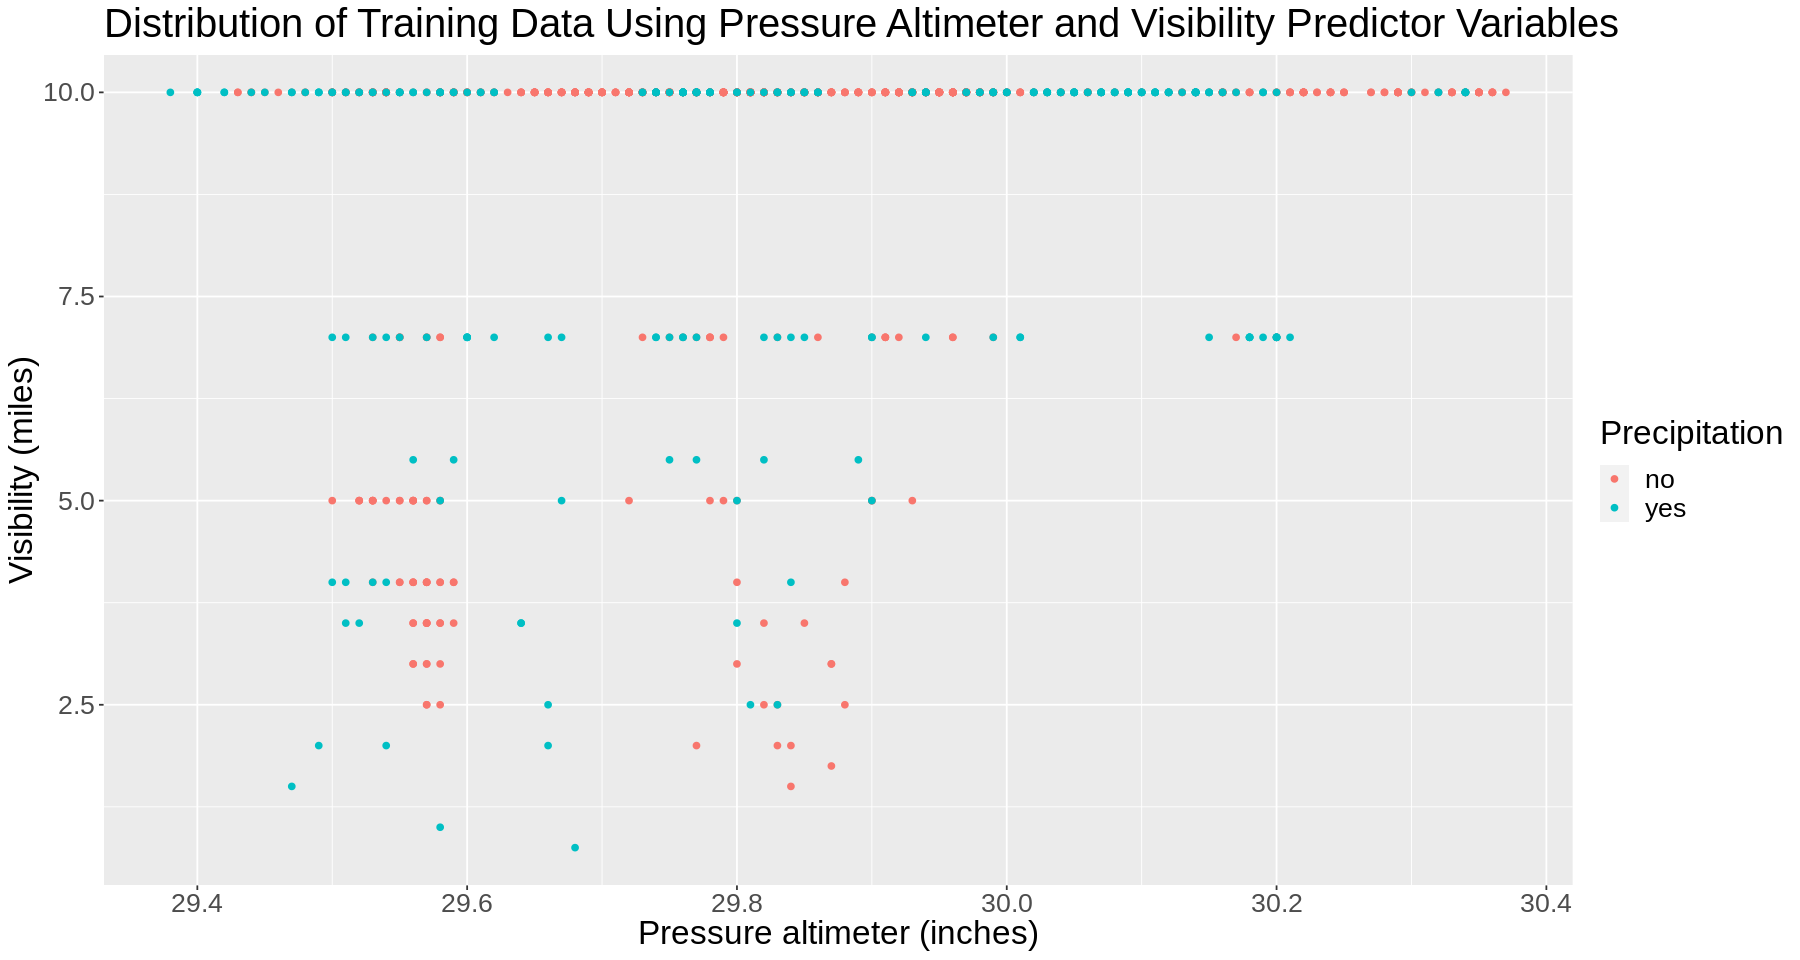

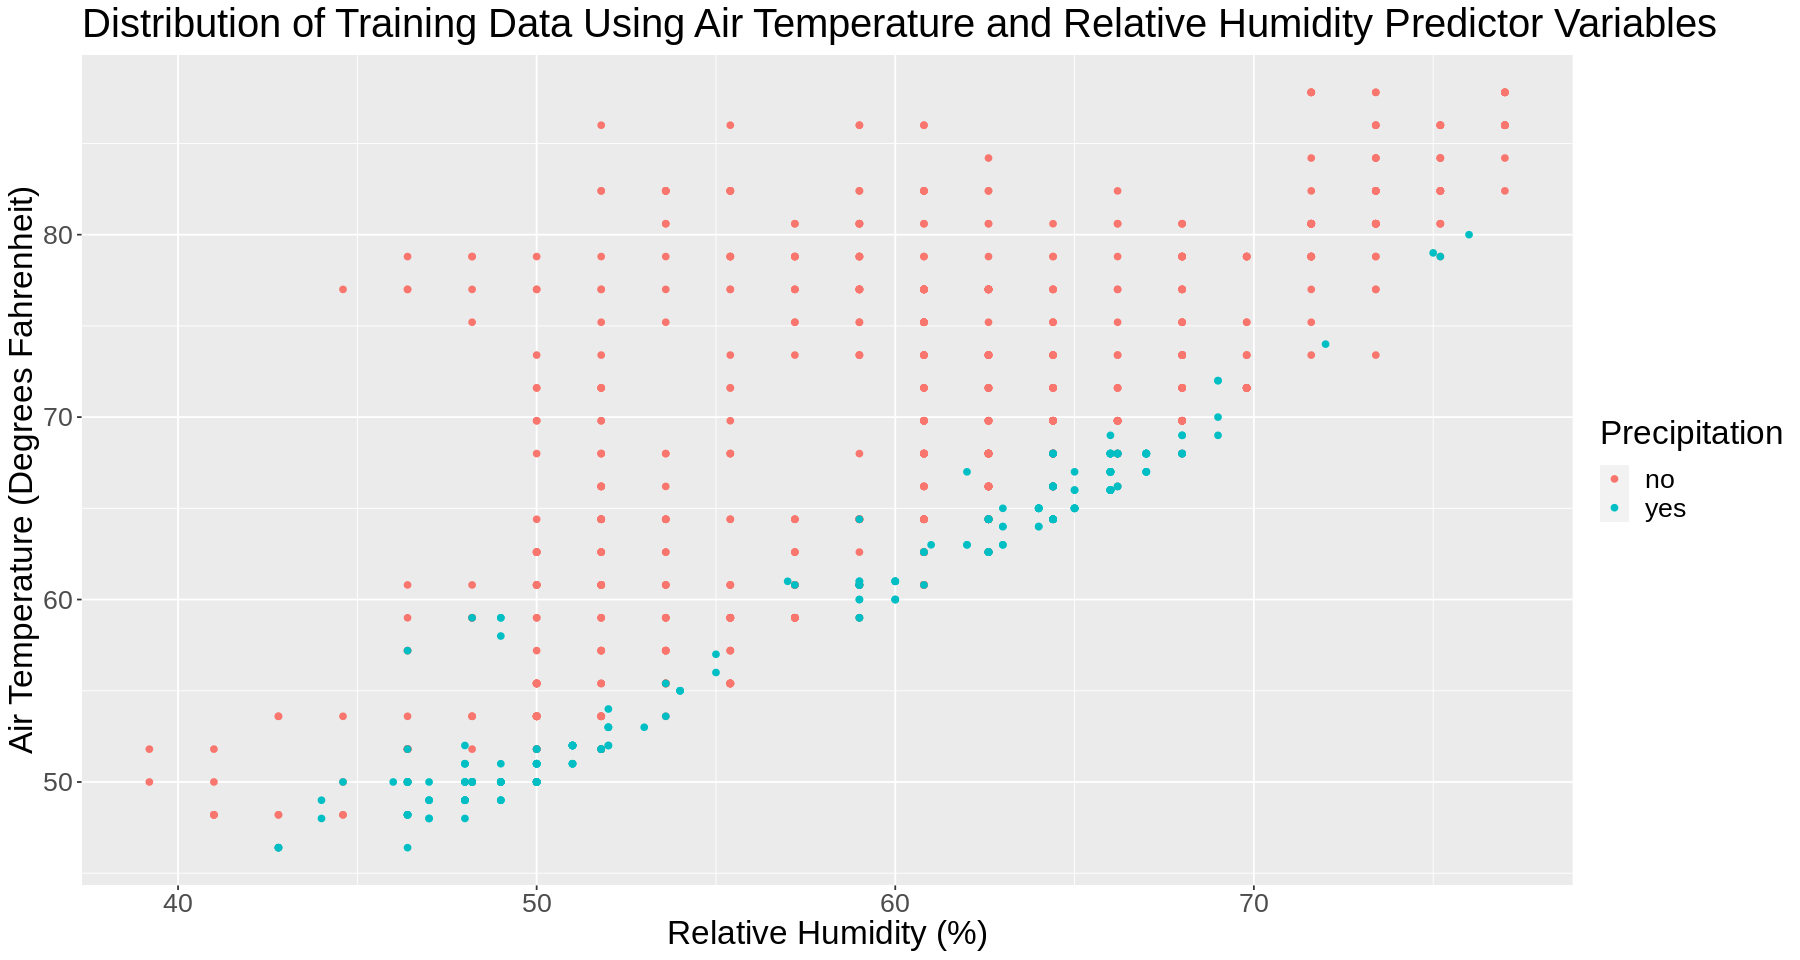

In [87]:
#exploratory data visualizations
options(repr.plot.height = 8, repr.plot.width = 15)
metar_vis1 <- metar_training |>
    ggplot(aes(y = vsby, x = alti, color = precip)) +
    geom_point() +
    theme(text = element_text(size = 20)) +
    labs(y = "Visibility (miles)", x = "Pressure altimeter (inches)", color = "Precipitation") +
    scale_color_hue(labels = c("no", "yes")) +
    ggtitle("Distribution of Training Data Using Pressure Altimeter and Visibility Predictor Variables")
metar_vis1

metar_vis2 <- metar_training |>
    ggplot(aes(y = tmpf, x = dwpf, color = precip)) +
    geom_point() +
    theme(text = element_text(size = 20)) +
    labs(y = "Air Temperature (Degrees Fahrenheit)", x = "Relative Humidity (%)", color = "Precipitation") +
    scale_color_hue(labels = c("no", "yes")) +
    ggtitle("Distribution of Training Data Using Air Temperature and Relative Humidity Predictor Variables")
metar_vis2

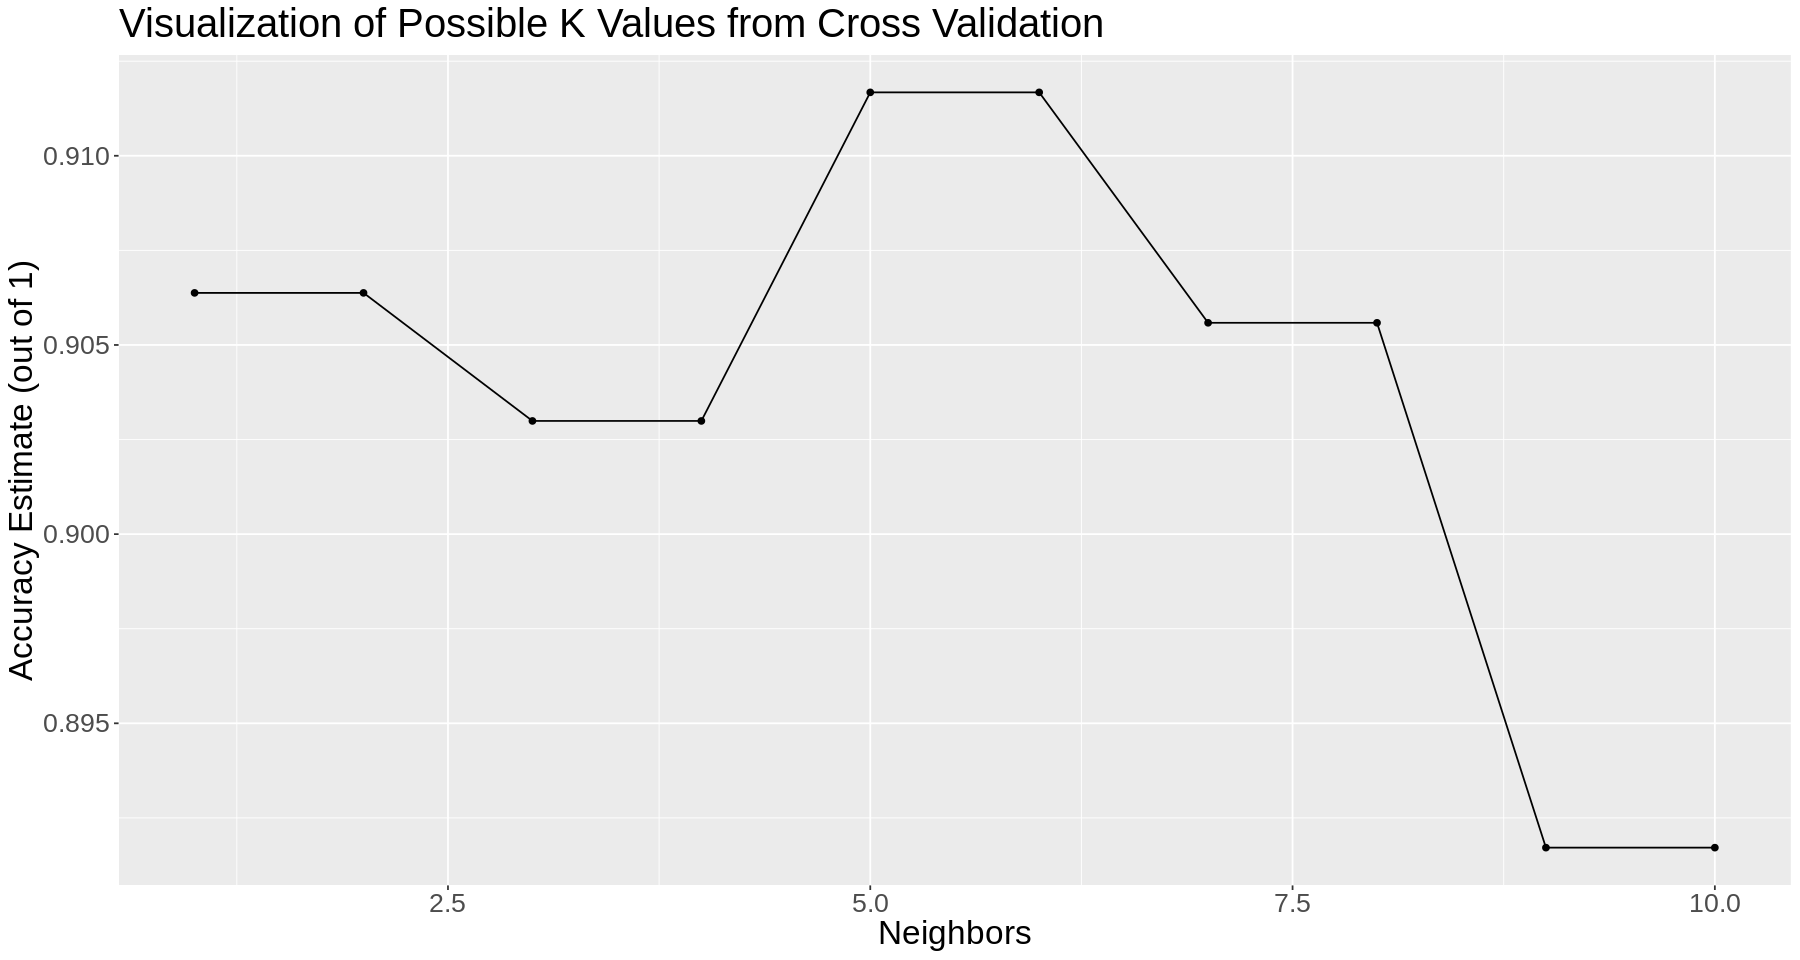

In [80]:
#generating recipe
metar_recipe <- recipe(precip ~ tmpf + dwpf + relh + drct + alti + vsby, data = metar_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#generating KNN model for cross validation
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#generating cross validation fold object
metar_vfold <- vfold_cv(metar_training, v = 5, strata = precip)

#generating grid of K values
k_vals <- tibble(neighbors = seq(1:10))

#creating workflow and computing cross validation accuracies
metar_results <- workflow() |>
    add_recipe(metar_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = metar_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

#plotting K values against accuracy to determine K
cross_val_plot <- metar_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate (out of 1)") +
    ggtitle("Visualization of Possible K Values from Cross Validation") +
    theme(text = element_text(size = 20))

cross_val_plot

From the plot above we determined the best choice was k = 6, since the accuracy is highest and only decreases slightly for K values on either side of 6.

In [81]:
#generating KNN model with best k value
metar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode("classification")

#generating final workflow
metar_fit <- workflow() |>
    add_recipe(metar_recipe) |>
    add_model(metar_spec) |>
    fit(data = metar_training)

#generating predictions
metar_predictions <- predict(metar_fit, metar_testing) |>
    bind_cols(metar_testing)

#computing prediction accuracies
metar_accuracy <- metar_predictions |>
    metrics(truth = precip, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

#comparing predictions to true values in a confusion matrix
metar_cm <- metar_predictions |>
    conf_mat(truth = precip, estimate =.pred_class)

In [82]:
metar_accuracy
metar_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.9428571


          Truth
Prediction   0   1
         0 291  14
         1   8  72

In [ ]:
#visualization of results


***Discussion***
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

**from the proposal**

    We expect to able to predict whether or not there is precipitation in Des Moines, Iowa at any given time between May 22 and June 15 2008. These findings are important as they not only allow us to determine if there is precipitation in Des Moines within the selected time frame, but could also help in discovering the "nowcast" of any point in time at any station from the data set within the date range provided using slight modifications to our original classification. The classification coded for could lead to future questions such as: Could a similar method be used to predict future forecasts this way? Could a classification be coded for in the future to distinguish the type of precipitation at that time point using the same dataset? There are numerous possibilities for future analysis by using this classification as a basis. 

***References***
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.
    - actual data file: https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=IKV&data=all&year1=2008&month1=5&day1=22&year2=2008&month2=6&day2=15&tz=Etc%2FUTC&format=onlycomma&latlon=no&elev=no&missing=empty&trace=T&direct=no&report_type=3&report_type=4
    - website we got it from:https://mesonet.agron.iastate.edu/request/download.phtml

**General notes/questions:**
- what qualifies as a "table" or a "figure"?
    - data visualizations and data tables?
- 2000 word written limit NOT INCLUDING CITATIONS